# **House Prices - Advanced Regression Techniques** 

(https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/) - *projekt na Uczenie Maszynowe*

*by Bartosz Rogowski & Aleksandra Rolka*


In [27]:
# running from Google collab
# -----------------------------------------------------------------
# from google.colab import drive
# drive.mount('/content/drive')

# !unzip drive/Shareddrives/ML-team/house-prices-advanced-regression-techniques.zip -d data
# data_folder_path = '/content/data'


# running locally
# -----------------------------------------------------------------
data_folder_path = './data/'

In [ ]:
!pip install shap

In [29]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import isnan
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer
import shap

## Przygotowanie danych

In [30]:
def encode_not_numeric_collumns(df):
  for column_name in df:
    if not is_numeric_dtype(df[column_name]):
      unique_values_dict = dict(enumerate(df[column_name].unique()))
      unique_values_dict = dict((v, k) for k, v in unique_values_dict.items())
      df[column_name] = df[column_name].map(unique_values_dict)
  return df

In [31]:
def convert_Nan_values(df, target_value=0):
  for column_name in df:
    df[column_name] = df[column_name].fillna(target_value)
  return df

In [32]:
def normalize_dataframe(df, columns_names):
    scaler = MinMaxScaler()
    df[columns_names] = scaler.fit_transform(df[columns_names])
    return df

In [33]:
def columns_to_drop_too_many_NaN(df, treshold=0.15):
  columns_names = []
  for column_name in df:
    count = sum(pd.isnull(df[column_name]))
    if count/len(column_name) > treshold:
      columns_names.append(column_name)
  return columns_names

In [34]:
def drop_columns(df, columns):
    for column_name in columns:
      df = df.drop([column_name], axis=1)
    return df

##### Wczytanie danych

In [35]:
train_data = pd.read_csv(data_folder_path+"/train.csv")
test_data_X = pd.read_csv(data_folder_path+"/test.csv")
test_data_Y = pd.read_csv(data_folder_path+"/sample_submission.csv")

In [36]:
train_data = train_data.drop(['Id'], axis=1)
test_data_X = test_data_X.drop(['Id'], axis=1)
test_data_Y = test_data_Y.drop(['Id'], axis=1)

##### Porzucanie kolumn w których brakuje dużo danych (mających wartości `NaN`)

In [37]:
columns_to_drop = columns_to_drop_too_many_NaN(train_data)
train_data = drop_columns(train_data, columns_to_drop)
test_data_X = drop_columns(test_data_X, columns_to_drop)

print("Dropped columns: ", columns_to_drop)

Dropped columns:  ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


##### Zakodowanie informacji nienumerycznych

In [38]:
train_data = encode_not_numeric_collumns(train_data)
test_data_X = encode_not_numeric_collumns(test_data_X)

##### Konwersja wartości `NaN`

In [39]:
train_data = convert_Nan_values(train_data)
test_data_X = convert_Nan_values(test_data_X)
test_data_Y = convert_Nan_values(test_data_Y)

##### Standaryzacja danych za pomocą `MinMaxScaler`

In [40]:
column_names_without_prices = [x for x in test_data_X]

In [41]:
train_data = normalize_dataframe(train_data, column_names_without_prices)
test_data_X = normalize_dataframe(test_data_X, column_names_without_prices)

##### Usunięcie danych skrajnych

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


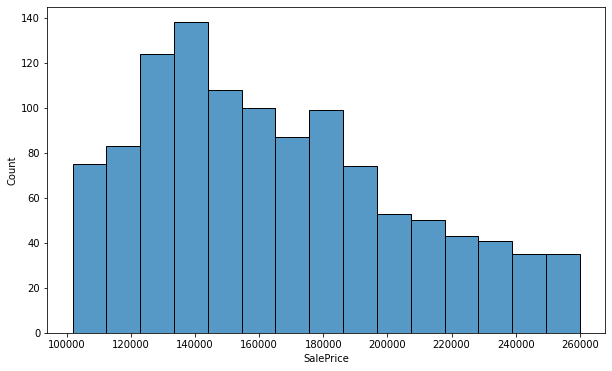

In [42]:
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm
scaler = StandardScaler()
train_data_copy = train_data.copy()
scaled_prices = np.array(scaler.fit_transform(train_data_copy['SalePrice'][:, np.newaxis]))
train_data_copy['SalePriceScaled'] = scaled_prices[:,0]
indeces_to_drop = train_data_copy[(train_data_copy['SalePriceScaled'] < -1) | (train_data_copy['SalePriceScaled'] > 1)].index
train_data = train_data_copy.drop(indeces_to_drop)
train_data = train_data.drop(['SalePriceScaled'], axis=1)
plt.figure(1, figsize=(10,6))
sns.histplot(data=train_data['SalePrice'])
plt.show()

-----

## Analiza danych

Number of columns containing high correlation: 21


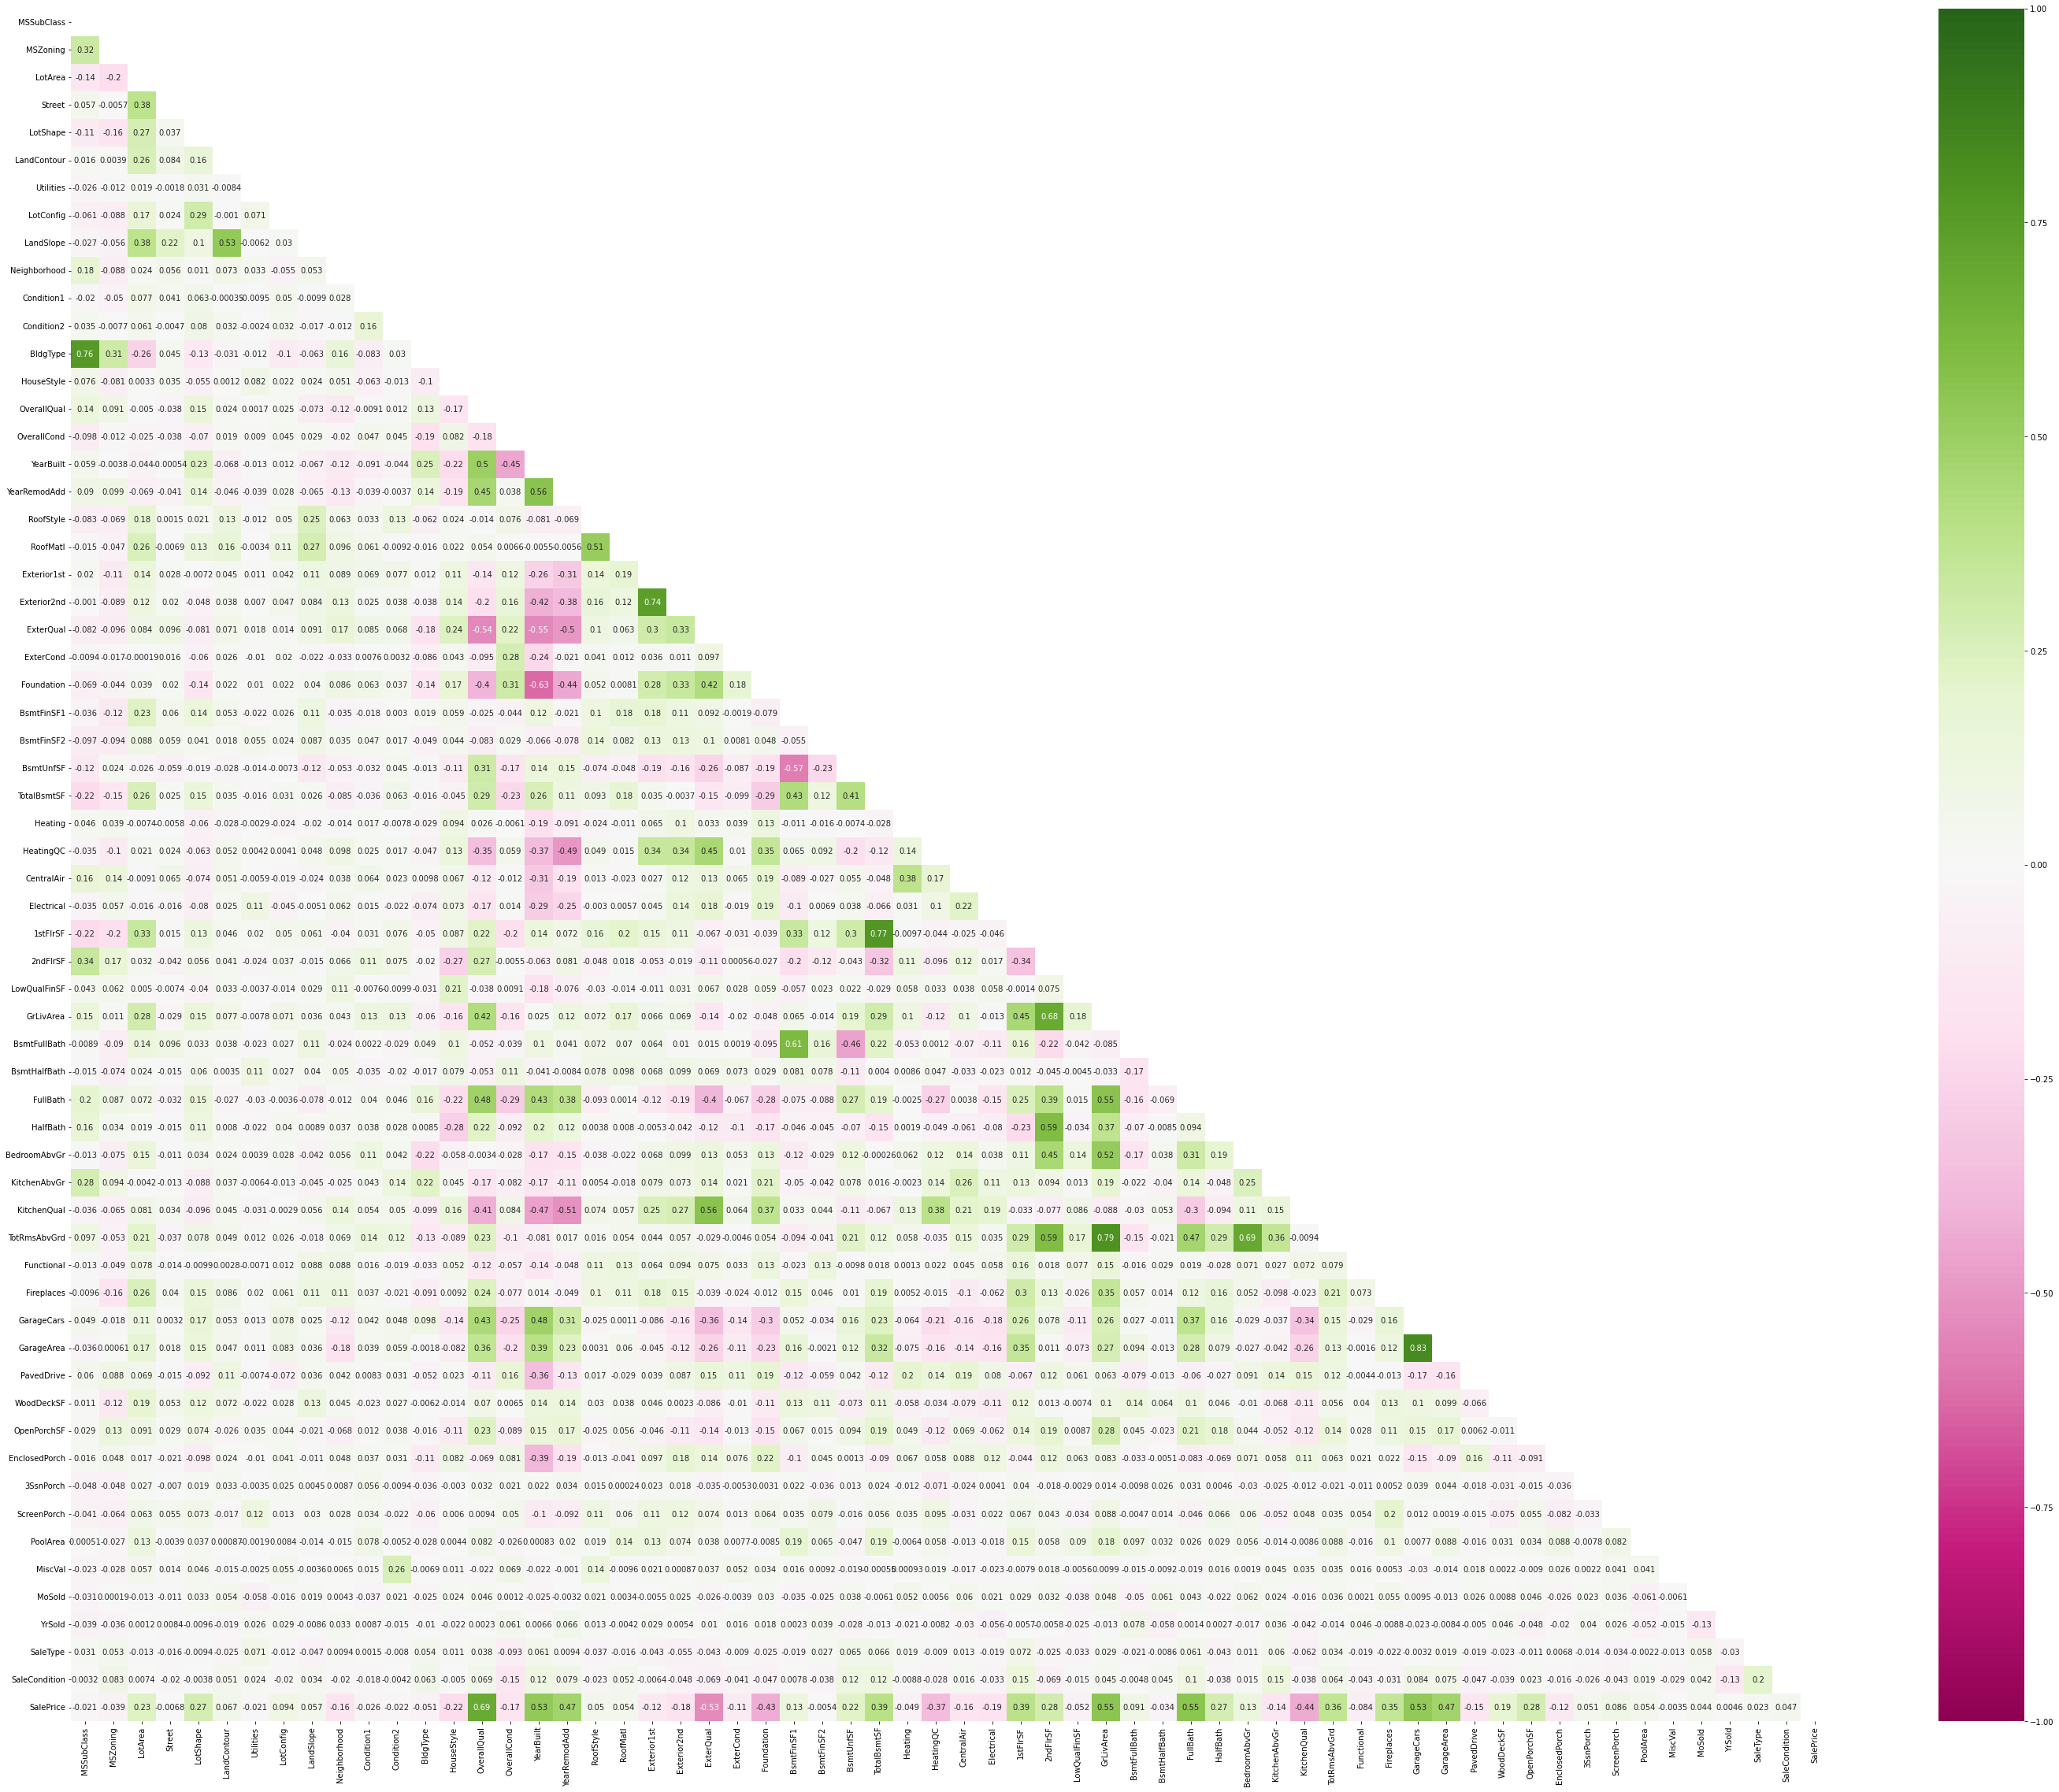

In [43]:
corr_threshold = 0.4
corr = train_data.corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca())
high_corr = []
for column in train_data:
   for col in train_data:
     if abs(lower_tri[column][col]) > corr_threshold:
       high_corr.append((column, col, lower_tri[column][col]))
high_corr = sorted(high_corr, key=lambda x: x[2], reverse=True)
print("Number of columns containing high correlation:", len(set([x[0] for x in high_corr])))

In [44]:
high_corr

[('GarageCars', 'GarageArea', 0.8322151800370637),
 ('GrLivArea', 'TotRmsAbvGrd', 0.793337984445501),
 ('TotalBsmtSF', '1stFlrSF', 0.7743429551204599),
 ('MSSubClass', 'BldgType', 0.7595017642135551),
 ('Exterior1st', 'Exterior2nd', 0.7411825569873141),
 ('BedroomAbvGr', 'TotRmsAbvGrd', 0.693687468049643),
 ('OverallQual', 'SalePrice', 0.6850701819335482),
 ('2ndFlrSF', 'GrLivArea', 0.6800806299161003),
 ('BsmtFinSF1', 'BsmtFullBath', 0.6060368259405682),
 ('2ndFlrSF', 'TotRmsAbvGrd', 0.5893880046882499),
 ('2ndFlrSF', 'HalfBath', 0.5880703556562575),
 ('ExterQual', 'KitchenQual', 0.5578533544216409),
 ('YearBuilt', 'YearRemodAdd', 0.5551226078831868),
 ('GrLivArea', 'FullBath', 0.5547945519564399),
 ('FullBath', 'SalePrice', 0.5537719602440158),
 ('GrLivArea', 'SalePrice', 0.553613897599182),
 ('LandContour', 'LandSlope', 0.5303431101578298),
 ('YearBuilt', 'SalePrice', 0.5278037905322465),
 ('GarageCars', 'SalePrice', 0.5257731570340404),
 ('GrLivArea', 'BedroomAbvGr', 0.521513867517

##### Porzucenie kolumn z wysokim wskaźnikiem korelacji

In [45]:
# drop columns with high correlation
train_data = train_data.drop([x[0] for x in high_corr if x[0] in train_data], axis=1)
test_data_X = test_data_X.drop([x[0] for x in high_corr if x[0] in test_data_X], axis=1)

In [46]:
train_data_X = train_data.drop(['SalePrice'], axis=1)
train_data_Y = train_data.loc[:,["SalePrice"]].to_numpy()
test_data_Y = test_data_Y.to_numpy()

-----
-----

# Predykcja za pomocą różnych metod:


*   regresja liniowa
*   regrsja z regularyzacją z metodą Lasso
*   regresja za pomocą Random Forest w XGBoost



## Regresja Liniowa

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(train_data_X,train_data_Y, )  
predicted = model.predict(test_data_X)

In [48]:
def results_sum_up(actual_prices, predicted_prices, show_n_elements=15):
    relative_error_list = []
    for i, (actual, predicted) in enumerate(zip(actual_prices, predicted_prices)):
        try:
            #sometimes values are stored in 1D arrays so we need to access them
            actual = actual[0]
            predicted = predicted[0]
        except:
            pass
        relative_error = np.abs((actual - predicted)/actual)
        relative_error_list.append(relative_error)
        if i < show_n_elements:
            print(f"Actual: {actual:.2f}\tPrediction: {predicted:.2f}\t\tDifference: {(100*relative_error):.2f}%")

    return np.sqrt(mean_squared_error(actual_prices, predicted_prices)), relative_error_list

##### Wyniki regresji liniowej

In [49]:
rmse, relative_errors = results_sum_up(test_data_Y, predicted)
print(f"\nRMSE = {rmse:.2f}\t mean(relative_erors) = {np.mean(relative_errors)*100:.2f}%")

Actual: 169277.05	Prediction: 156087.35		Difference: 7.79%
Actual: 187758.39	Prediction: 186144.37		Difference: 0.86%
Actual: 183583.68	Prediction: 174189.48		Difference: 5.12%
Actual: 179317.48	Prediction: 170862.48		Difference: 4.72%
Actual: 150730.08	Prediction: 128132.09		Difference: 14.99%
Actual: 177150.99	Prediction: 177049.16		Difference: 0.06%
Actual: 172070.66	Prediction: 144420.84		Difference: 16.07%
Actual: 175110.96	Prediction: 172827.26		Difference: 1.30%
Actual: 162011.70	Prediction: 151748.85		Difference: 6.33%
Actual: 160726.25	Prediction: 136636.43		Difference: 14.99%
Actual: 157933.28	Prediction: 145970.90		Difference: 7.57%
Actual: 145291.25	Prediction: 131518.77		Difference: 9.48%
Actual: 159672.02	Prediction: 137280.35		Difference: 14.02%
Actual: 164167.52	Prediction: 147798.90		Difference: 9.97%
Actual: 150891.64	Prediction: 95735.57		Difference: 36.55%

RMSE = 47709.25	 mean(relative_erors) = 22.80%


-----

## Regresja z regularyzacją Lasso

In [50]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.005, max_iter=50000)
model.fit(train_data_X, train_data_Y)
predicted = model.predict(test_data_X)

##### Wyniki regresji z regularyzacją Lasso

In [51]:
rmse, relative_errors = results_sum_up(test_data_Y, predicted)
print(f"\nRMSE = {rmse:.2f}\t mean(relative_erors) = {np.mean(relative_errors)*100:.2f}%")

Actual: 169277.05	Prediction: 156086.10		Difference: 7.79%
Actual: 187758.39	Prediction: 186138.97		Difference: 0.86%
Actual: 183583.68	Prediction: 174187.98		Difference: 5.12%
Actual: 179317.48	Prediction: 170861.60		Difference: 4.72%
Actual: 150730.08	Prediction: 128131.92		Difference: 14.99%
Actual: 177150.99	Prediction: 177048.29		Difference: 0.06%
Actual: 172070.66	Prediction: 144420.26		Difference: 16.07%
Actual: 175110.96	Prediction: 172826.68		Difference: 1.30%
Actual: 162011.70	Prediction: 151748.06		Difference: 6.34%
Actual: 160726.25	Prediction: 136635.92		Difference: 14.99%
Actual: 157933.28	Prediction: 145970.81		Difference: 7.57%
Actual: 145291.25	Prediction: 131519.18		Difference: 9.48%
Actual: 159672.02	Prediction: 137280.73		Difference: 14.02%
Actual: 164167.52	Prediction: 147799.31		Difference: 9.97%
Actual: 150891.64	Prediction: 95736.01		Difference: 36.55%

RMSE = 47709.69	 mean(relative_erors) = 22.80%


-----

## Random Forest Regression

In [52]:
import xgboost as xgb

model = xgb.XGBRegressor(
                 colsample_bytree=0.05,
                 gamma=0.0,
                 learning_rate=0.0005,
                 max_depth=6,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42)
model.fit(train_data_X, train_data_Y)
predicted = model.predict(test_data_X)

##### Wyniki regresji z wykorzystaniem Random Forest w XGBoost

In [53]:
rmse, relative_errors = results_sum_up(test_data_Y, predicted)
print(f"\nRMSE = {rmse:.2f}\t mean(relative_erors) = {np.mean(relative_errors)*100:.2f}%")

Actual: 169277.05	Prediction: 161469.53		Difference: 4.61%
Actual: 187758.39	Prediction: 161464.67		Difference: 14.00%
Actual: 183583.68	Prediction: 165966.39		Difference: 9.60%
Actual: 179317.48	Prediction: 167357.88		Difference: 6.67%
Actual: 150730.08	Prediction: 152138.12		Difference: 0.93%
Actual: 177150.99	Prediction: 165250.94		Difference: 6.72%
Actual: 172070.66	Prediction: 152701.33		Difference: 11.26%
Actual: 175110.96	Prediction: 166956.22		Difference: 4.66%
Actual: 162011.70	Prediction: 158673.19		Difference: 2.06%
Actual: 160726.25	Prediction: 154694.95		Difference: 3.75%
Actual: 157933.28	Prediction: 164153.17		Difference: 3.94%
Actual: 145291.25	Prediction: 151857.05		Difference: 4.52%
Actual: 159672.02	Prediction: 145821.00		Difference: 8.67%
Actual: 164167.52	Prediction: 150402.91		Difference: 8.38%
Actual: 150891.64	Prediction: 142381.09		Difference: 5.64%

RMSE = 29258.23	 mean(relative_erors) = 13.64%


### Grid search po parametrach w celu wybrania najbardziej optymalnego zestawu

In [54]:
def mean_relative_error(actual_prices, predicted_prices):
    relative_error_list = []
    for i, (actual, predicted) in enumerate(zip(actual_prices, predicted_prices)):
        try:
            actual = actual[0]
            predicted = predicted[0]
        except:
            pass
        relative_error = np.abs((actual - predicted)/actual)
        relative_error_list.append(relative_error)

    return - np.mean(relative_error_list)*100

custom_scorer = make_scorer(mean_relative_error, greater_is_better=False)

In [55]:
# model = xgb.XGBRegressor(objective='reg:squarederror')
# parameters = {'nthread' : [4],              
#               'colsample_bytree' : list(np.arange(0.02, 0.1, 0.02)),
#               'gamma' : [0.0],
#               'learning_rate' : list(np.arange(0.0003, 0.0008, 0.0001)),
#               'max_depth' : list(np.arange(4, 9, 1)),
#               'min_child_weight' : [1.5],
#               'n_estimators' : list(np.arange(5000, 8000, 800)),
#               'reg_alpha' : [0.9],
#               'reg_lambda' : [0.6],
#               'subsample' : [0.2],
#               'seed' : [42] }


# model_xgb_grid = GridSearchCV(estimator=model,
#                         param_grid=parameters,
#                         # cv=2,
#                         n_jobs=8,
#                         scoring=custom_scorer,
#                         verbose=10
#                         )

# model_xgb_grid.fit(train_data_X, train_data_Y)

# print(model_xgb_grid.best_score_)
# print(model_xgb_grid.best_params_)

##### Wyniki Grid Search'a

Best parameters:

* przypadek bez usuniętych kolumn zawierających dużą ilość wartości NaN

{'colsample_bytree': 0.02, 'gamma': 0.0, 'learning_rate': 0.0005, 'max_depth': 4, 'min_child_weight': 1.5, 'n_estimators': 7400, 'nthread': 4, 'reg_alpha': 0.9, 'reg_lambda': 0.6, 'seed': 42, 'subsample': 0.2}

------

* z usuniętymi kolumnami z dużą ilością wartości NaN

{'colsample_bytree': 0.02, 'gamma': 0.0, 'learning_rate': 0.0006999999999999999, 'max_depth': 4, 'min_child_weight': 1.5, 'n_estimators': 5800, 'nthread': 4, 'reg_alpha': 0.9, 'reg_lambda': 0.6, 'seed': 42, 'subsample': 0.2}

##### Wytrenowanie modelu na znalezionym najlepszym zestawie parametrów

In [56]:
model = xgb.XGBRegressor(colsample_bytree=0.02,
                         gamma=0.0, 
                         learning_rate=0.0006999999999999999,
                         max_depth=4,
                         min_child_weight=1.5,
                         n_estimators=5800,
                         nthread=4,
                         reg_alpha=0.9,
                         reg_lambda=0.6,
                         seed=42,
                         subsample=0.2)

# model = xgb.XGBRegressor(
#     **model_xgb_grid.best_params_
# )
model.fit(train_data_X, train_data_Y)
predicted = model.predict(test_data_X)
rmse, relative_errors = results_sum_up(test_data_Y, predicted)
print("\nRMSE = {:.2f}\t mean(relative_erors) = {:.2f}%".format(rmse, np.mean(relative_errors)*100))

Actual: 169277.05	Prediction: 163210.19		Difference: 3.58%
Actual: 187758.39	Prediction: 163340.70		Difference: 13.00%
Actual: 183583.68	Prediction: 166286.30		Difference: 9.42%
Actual: 179317.48	Prediction: 166698.53		Difference: 7.04%
Actual: 150730.08	Prediction: 155543.56		Difference: 3.19%
Actual: 177150.99	Prediction: 164745.95		Difference: 7.00%
Actual: 172070.66	Prediction: 156490.84		Difference: 9.05%
Actual: 175110.96	Prediction: 166540.39		Difference: 4.89%
Actual: 162011.70	Prediction: 160989.80		Difference: 0.63%
Actual: 160726.25	Prediction: 158556.61		Difference: 1.35%
Actual: 157933.28	Prediction: 164692.91		Difference: 4.28%
Actual: 145291.25	Prediction: 157080.00		Difference: 8.11%
Actual: 159672.02	Prediction: 152426.25		Difference: 4.54%
Actual: 164167.52	Prediction: 155400.94		Difference: 5.34%
Actual: 150891.64	Prediction: 149934.28		Difference: 0.63%

RMSE = 26369.15	 mean(relative_erors) = 11.86%


-----

## Analiza SHAP

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


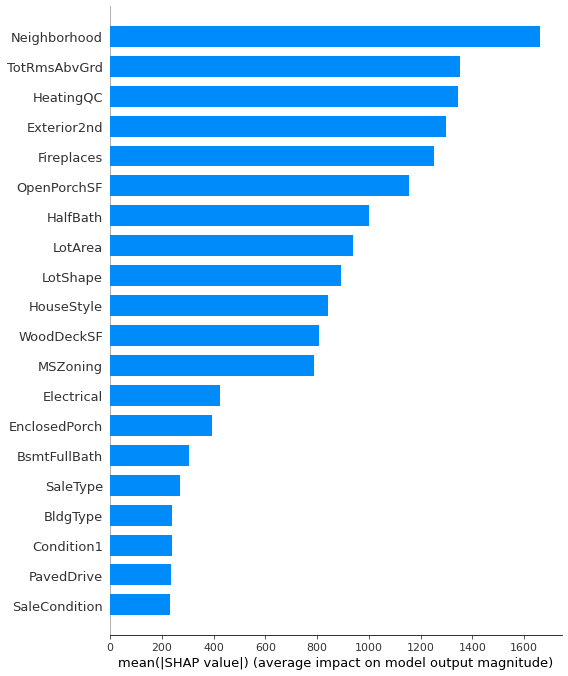

In [57]:
shap_values = shap.TreeExplainer(model).shap_values(train_data_X)
shap.summary_plot(shap_values, train_data_X, plot_type="bar")

In [58]:
for x in train_data_X:
    print(x)

MSZoning
LotArea
Street
LotShape
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofMatl
Exterior2nd
ExterCond
BsmtFinSF2
Heating
HeatingQC
CentralAir
Electrical
LowQualFinSF
BsmtFullBath
BsmtHalfBath
HalfBath
KitchenAbvGr
TotRmsAbvGrd
Functional
Fireplaces
PavedDrive
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MoSold
YrSold
SaleType
SaleCondition
